In [1]:
#pySnowRadar modules
import sys
%matplotlib inline

# from pySnowRadar import SnowRadar
# from pySnowRadar.processing import extract_layers
# from pySnowRadar.algorithms import Wavelet_TN, Peakiness

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *
import pickle

#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py
import cmasher as cmr
import xarray as xr
from scipy.stats import linregress
import matplotlib.colors as mcolors
from pyproj import Transformer
from shapely.geometry import Polygon, Point, MultiPoint, LineString
from shapely import affinity

import numpy as np
import shapely
import seaborn as sns
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)


pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('Blues')(range(ncolors))
color_array[:,-1] = np.linspace(0.2,1,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array)
# 
# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from scipy.constants import speed_of_light


import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

import geopandas as gpd

In [2]:
sites = [2, 3, 4, 'grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']
rolling_windows = [2, 5, 10, 20, 40]
#opening ATM grids
path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
files = os.listdir(path_ATM)
ATM_data_dict = {}
# print('Opening ATM data:')
for site in sites:
    file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
    # print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_ATM, file))
    ATM_data_dict[site] = ds
# print('------------------')


#opening MP grids
path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue'
files = os.listdir(path_MP)
files = [f for f in files if f.endswith('.nc')] 
MP_data_dict = {}
# MP_data_rolled_dict = {}

# print('Opening and rolling MP data:')
for site in sites:
    # MP_data_rolled_dict[site] = {}
    file = [x for x in files if x.split('_')[1] == str(site)][0]
    # print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_MP, file))
    MP_data_dict[site] = ds
    # for r in rolling_windows:
    #     MP_data_rolled_dict[site][r] = ds.rolling(easting=r, northing=r, min_periods=r, center=True).mean()
# print('------------------')



#opening SR data (Wavelet)
path_SR_Wavelet = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Wavelet/20250204_SRprecision'
SR_Wavelet_data_dict = {}
# print('Opening SR Wavelet data:')
for site in sites:
    SR_Wavelet_data_dict[site] = {}
    subpath = os.path.join(path_SR_Wavelet, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Wavelet, str(site), f))
        SR_Wavelet_data_dict[site][i] = ds
# print('------------------')


#opening SR data (Peakiness)
path_SR_Peakiness = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness/20250204_SRprecision'
SR_Peakiness_data_dict = {}
# print('Opening SR Peakiness data:')

for site in sites:
    SR_Peakiness_data_dict[site] = {}
    subpath = os.path.join(path_SR_Peakiness, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        # print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Peakiness, str(site), f))
        SR_Peakiness_data_dict[site][i] = ds
        
        
#opening SR data (Quicklook)
path_SR_Quicklook = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Quicklook/subset'
files = os.listdir(path_SR_Quicklook)
files = np.sort(files)
QL_dict = {}
for i, site in enumerate(sites):
    df = pd.read_csv(os.path.join(path_SR_Quicklook, files[i]), index_col=0)
    df['site'] = [site]*len(df)
    df.reset_index(inplace=True)
    print(site, len(df))
    QL_dict[site] = df[['x','y','snow_depth','snow_depth_unc','site']]



#opening shapefiles
path_shapefiles = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4'
shape_dict = {}
for site in sites:
    file = [x for x in os.listdir(path_shapefiles) if x.split('_')[1] == str(site) and x.endswith('shp')][0]
    # print(f'{site}: {file}')

    shape_dict[site] = gpd.read_file(os.path.join(path_shapefiles, file))

2 51
3 81
4 83
grid3 41
grid4 27
grid5 0
grid6 65
grid7 64
grid8 27


In [3]:

############
# 
footprint_mode = 'pulse_limited_unfocused'
include_moving_windows = True

if include_moving_windows:
    moving_windows = [3,5,7,9,]
    
############

df_master_dict = {}
df_tmp_dict = {}

for site in tqdm(sites):
    df_tmp_dict[site] = {}
    
    for i in SR_Wavelet_data_dict[site].keys():
        ds =  SR_Wavelet_data_dict[site][i]
        df_tmp = SR_Wavelet_data_dict[site][i].to_dataframe().loc[0]
        
        df_tmp_tmp = SR_Peakiness_data_dict[site][i].to_dataframe().loc[0]
        df_tmp_tmp.reset_index(inplace=True)
        
        df_tmp['air_snow_elevation_peakiness'] = df_tmp_tmp['air_snow_elevation'].to_list()
        df_tmp['snow_ice_elevation_peakiness'] = df_tmp_tmp['snow_ice_elevation'].to_list()
        df_tmp['snow_depth_peakiness'] = df_tmp_tmp['snow_depth'].to_list()
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'air_snow_elevation_rolled_{length}'] = df_tmp['air_snow_elevation'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_ice_elevation_rolled_{length}'] = df_tmp['snow_ice_elevation'].rolling(window=length, min_periods=1, center=True).mean()
                
                df_tmp[f'air_snow_elevation_peak_rolled_{length}'] = df_tmp['air_snow_elevation_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_ice_elevation_peak_rolled_{length}'] = df_tmp['snow_ice_elevation_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
            
        # print()
        # waveforms = []
        # for k in range(len(df_tmp)):
        #     waveforms.append(SR_Wavelet_data_dict[site][i]['radar_data'].values[:,k])
            
        # df_tmp['waveform'] = waveforms 
        
        df_tmp.reset_index(inplace=True)
        # break
        #add site, ice age and overflight information
        df_tmp['site'] = [site] * len(df_tmp)    
        df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
        df_tmp['overflight_nr'] = [i] * len(df_tmp) 

        #add footprints
        df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
        # sr_footprints = [affinity.scale(fp, xfact=scale, yfact=scale) for fp in sr_footprints]
        
        df_tmp['footprints'] = sr_footprints
        df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)

        xx, yy = np.meshgrid(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], indexing='xy')
        zz_ATM = ATM_data_dict[site]['elevation'].values.flatten()

        mask = ~np.isnan(zz_ATM)
        xx = xx.flatten()[mask]
        yy = yy.flatten()[mask]

        poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(xx, yy)), np.mean(df_tmp['footprint_area']) * .65 if footprint_mode == 'pulse_limited_unfocused' else 1)
        wavelet_indices = list(poly_points_indices_wavelet.keys())
        df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

        df_tmp['grid_indices'] = poly_points_indices_wavelet
        df_tmp['grid_x'] = df_tmp['grid_indices'].apply(lambda x: xx[x])
        df_tmp['grid_y'] = df_tmp['grid_indices'].apply(lambda x: yy[x])
        df_tmp['grid_dists'] = df_tmp.apply(lambda x: np.sqrt((x.grid_x - x.x)**2 + (x.grid_y - x.y)**2), axis=1)        

        # add ATM 
        df_tmp['ATM_elev'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['elevation'].values.flatten()[mask][x])
        df_tmp['ATM_elev_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['standard_deviation'].values.flatten()[mask][x])    
        df_tmp['ATM_htopo'] = df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .95) - np.quantile(x, .05))
        df_tmp['ATM_slope'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['slope'].values.flatten()[mask][x])
        df_tmp['ATM_roughness'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['roughness'].values.flatten()[mask][x])
        df_tmp['deformation'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['classes'].values.flatten()[mask][x])
        df_tmp['deformation_flag'] = df_tmp['deformation'].apply(lambda x: 1 if np.nanmedian(x) > .1 else 0)

        # add MP
        df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth'].values.flatten()[mask][x])
        df_tmp['MP_snow_depth_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth_uncertainty'].values.flatten()[mask][x])
        

            # df_tmp['MP_snow_depth_uncerainty_rolled'] = roll_MP_snow_depth(df_tmp, length)
            
        # add the rolled MP
        # for r in rolling_windows:
        #     df_tmp[f'MP_snow_depth_{r}'] = df_tmp['grid_indices'].apply(lambda x: MP_data_rolled_dict[site][r]['snow_depth'].values.flatten()[mask][x])
        #     df_tmp[f'MP_snow_depth_uncertainty_{r}'] = df_tmp['grid_indices'].apply(lambda x: MP_data_rolled_dict[site][r]['snow_depth_uncertainty'].values.flatten()[mask][x])
            
        offset_wavelet = np.mean(df_tmp['air_snow_elevation'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        offset_peakiness = np.mean(df_tmp['air_snow_elevation_peakiness'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
                
                df_tmp[f'ATM_elev_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='ATM_elev', window_size=length)
                df_tmp[f'ATM_elev_wavelet_rolled_{length}'] = df_tmp[f'ATM_elev_rolled_{length}'].apply(lambda x: x + offset_wavelet)
            
        df_tmp['ATM_elev_wavelet'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_wavelet)
        df_tmp['ATM_elev_peakiness'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_peakiness)

        df_tmp = df_tmp.loc[(abs(df_tmp['roll']) < 3) & abs((df_tmp['pitch']) < 3)]
        df_tmp = df_tmp.loc[df_tmp['MP_snow_depth'].apply(lambda x: len(x[~np.isnan(x)]) > 10)]

        df_tmp.reset_index(inplace=True, drop=True)
        
        if len (df_tmp) > 0:
            df_tmp_dict[site][i] = df_tmp
        
            if i == list(SR_Wavelet_data_dict[site].keys())[0]:
                df_master = df_tmp
            else:
                df_master = pd.concat([df_master, df_tmp], axis=0)
            
        df_master.reset_index(inplace=True, drop=True)
        
    if site == 2:
        df_supermaster = df_master
    else:
        df_supermaster = pd.concat([df_supermaster, df_master], axis=0)
        
    df_master_dict[site] = df_master
    
df_supermaster.reset_index(inplace=True, drop=True)


df_supermaster['snow_depth_MAX'] = df_supermaster['ATM_elev'].apply(lambda x: np.nanmean(x)) -  df_supermaster['max_elevation']

100%|██████████| 9/9 [05:34<00:00, 37.13s/it]


### Rolling window analysis

In [15]:
Rs = []
RMSEs = []
BIASs = []
# sites_2014 = [2,3,4]
# sites_2016 = ['grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']

for length in moving_windows:
    print(length)
    mask = (df_supermaster['deformation_flag'] == 0) &  (df_supermaster['ice_age'] == 'fyi') #& (df_supermaster['site'].isin(sites))
    x = df_supermaster[f'ATM_elev_wavelet_rolled_{length}'].apply(lambda x: np.nanquantile(x,.5))[mask] - df_supermaster[f'MP_snow_depth_rolled_{length}'].apply(lambda x: np.nanquantile(x,.5))[mask]
    
    y = df_supermaster[f'snow_ice_elevation_rolled_{length}'][mask]
    
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    linr = linregress(x, y)
    Rs.append(linr.rvalue)
    RMSEs.append(linr.stderr)
    BIASs.append(np.nanmean(y - x))

Rs = np.array(Rs)
RMSEs = np.array(RMSEs)
BIASs = np.array(BIASs)




3
5
7
9
11
13
17
21
25


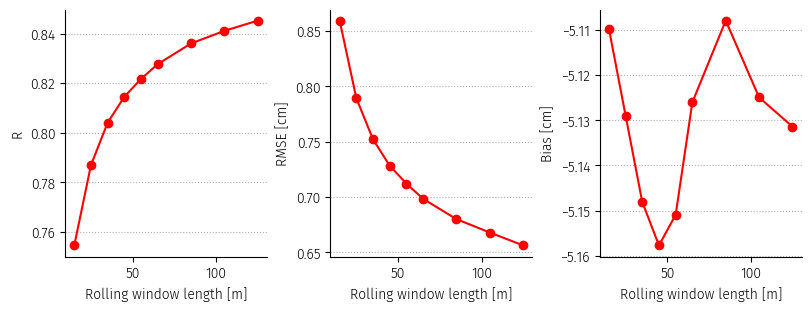

In [16]:

fig, ax = plt.subplots(1, 3, figsize=(8,3), constrained_layout=True)

ax[0].plot(np.multiply(moving_windows, 5), Rs, label='R', marker='o', color='red')
ax[1].plot(np.multiply(moving_windows, 5), RMSEs * 100, marker='o', color='red')
ax[2].plot(np.multiply(moving_windows, 5), BIASs * 100, marker='o', color='red')

ax[0].set_ylabel('R')
ax[1].set_ylabel('RMSE [cm]')
ax[2].set_ylabel('Bias [cm]')

for i in range(len(ax)):
    ax[i].set_xlabel('Rolling window length [m]')
    ax[i].grid(ls=':', axis='y')
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')

### Correlation A|S

Text(0.5, 0, '$\\overline{\\text{H}_{\\text{e, ATM}}}$  [m]')

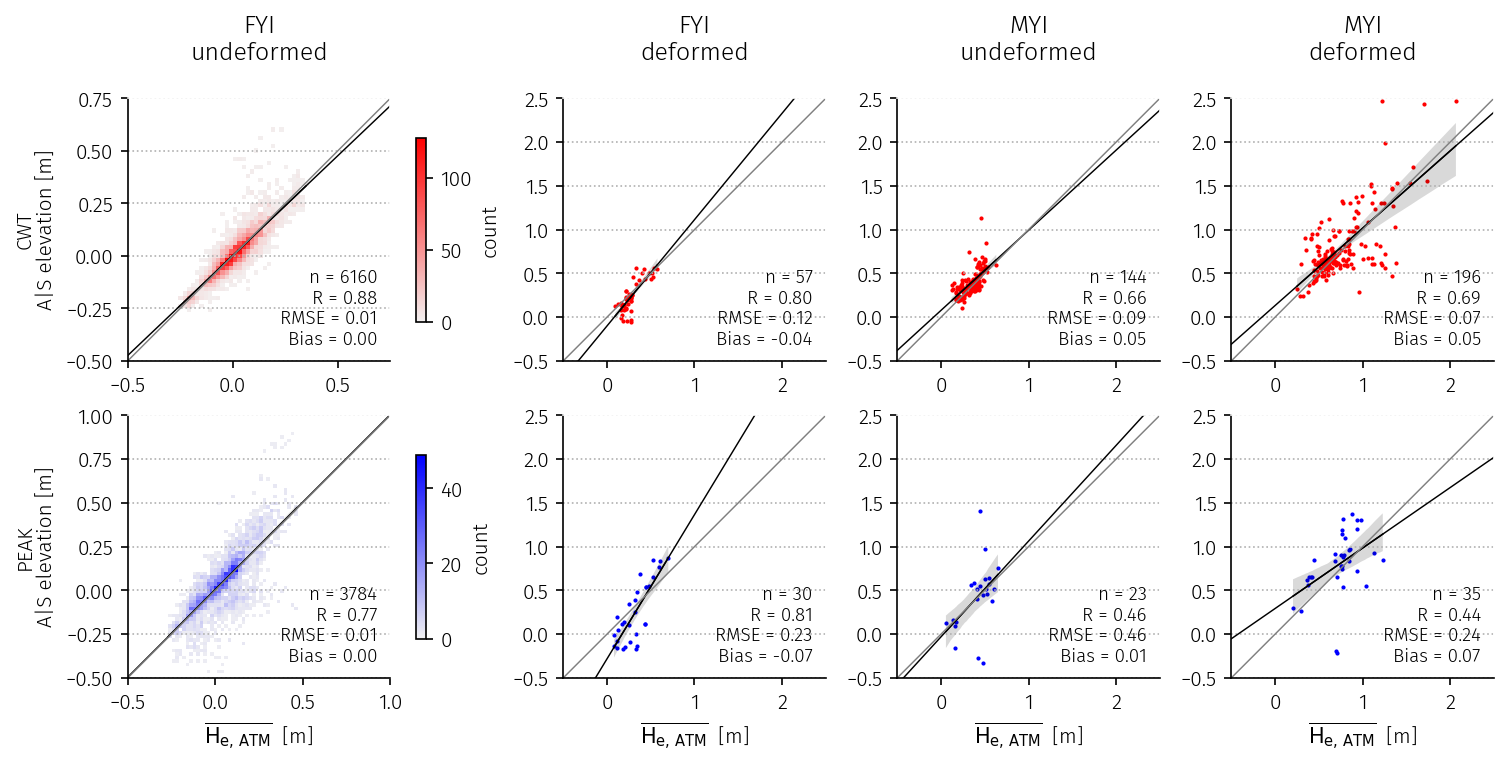

In [8]:
fig, ax = plt.subplots(2,4, constrained_layout=True, figsize=(10,5), dpi=150)
xs = np.linspace(-.5,2.5,100)
colors = ['red', 'blue']
cmaps = [sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True)]

ax = ax.ravel()
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)

k = 0
color_k = 0

for var, ATM_var in zip(['air_snow_elevation', 'air_snow_elevation_peakiness'], ['ATM_elev_wavelet', 'ATM_elev_peakiness']):
  
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
    x = df_supermaster[ATM_var].apply(lambda x: np.nanquantile(x,.5))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    hist = sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                cbar_kws={'shrink': .7, 'label': 'count'},
                stat='count'
                )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    
    #########
    
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
    x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    #########

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
    x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    #########
    
    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
    x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]
    y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1


  
 
for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([-0.5, 2.5])
    ax[i].set_ylim([-0.5, 2.5])
    ax[i].plot([-.5, 2.5], [-.5, 2.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')


ax[0].set_xlim([-.5, .75])
ax[0].set_ylim([-.5, .75])
ax[0].set_ylabel('CWT\nA|S elevation [m]')

ax[4].set_xlim([-.5, 1])
ax[4].set_ylim([-.5, 1])
ax[4].set_ylabel('PEAK\nA|S elevation [m]')


# ax[0].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[1].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[2].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[3].set_xlabel('ATM elevation [m]\n(90% quantile)')


ax[4].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$  [m]')
ax[5].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$  [m]')
ax[6].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$  [m]')
ax[7].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$  [m]')

### Which quantile of the a|s is the cwt finding 

In [22]:
from collections import Counter

deformation_flag = 0
algorithm_flag = 'CWT'

if algorithm_flag == 'CWT':
    var2 = 'ATM_elev_wavelet'
else:
    var2 = 'ATM_elev_peakiness'


if deformation_flag == 0:
    upper_bound = 1
    step = 0.1
    step1 = 0.2
else:
    upper_bound = 2.5
    step = 0.1
    step1 = 0.3
    
    

def custom_counter(data, upper_bound=1):
    counter = Counter(data)
    result = {}
    for key, value in counter.items():
        if key >= upper_bound:
            result[upper_bound] = result.get(upper_bound, 0) + value
        else:
            result[key] = value
    return dict(sorted(result.items()))

def custom_counter2(data, upper_bound=0.6):
    counter = Counter(data)
    result = {}
    for key, value in counter.items():
        if key >= upper_bound:
            result[upper_bound] = result.get(upper_bound, 0) + value
        else:
            result[key] = value
    return dict(sorted(result.items()))


quantiles = []
quantiles_inds = []
non_quantiles = 0
quantiles_sds = []
a_s_elevations = {}
over_a_s_elevations = []
under_a_s_elevations = []

df_supermaster_subset = df_supermaster.loc[df_supermaster['deformation_flag'] == deformation_flag]
df_supermaster_subset.reset_index(inplace=True, drop=True)
for i in np.arange(0,11,1):
    a_s_elevations[i] = []
    
for i in trange(len(df_supermaster_subset)):
    
    mask = np.isnan(df_supermaster_subset.loc[i,var2])
    quants = pd.qcut(df_supermaster_subset.loc[i,var2][~mask], 10, duplicates='drop')

    sr_sd = df_supermaster_subset.loc[i,'air_snow_elevation_peakiness' if algorithm_flag == 'PEAK' else 'air_snow_elevation']
    
    if True in quants.categories.contains(sr_sd):
        quant = np.argmax(quants.categories.contains(sr_sd))
        quantiles.append(quant)
        a_s_elevations[quant].append(np.round((quants[quant].right + quants[quant].left)/2/step1)*step1)

    elif sr_sd > np.max(df_supermaster_subset.loc[i,var2][~mask]):
        over_a_s_elevations.append(np.round((sr_sd - np.max(df_supermaster_subset.loc[i,var2][~mask]))/step)*step)
        
    elif sr_sd < np.min(df_supermaster_subset.loc[i,var2][~mask]):
        under_a_s_elevations.append(np.round((np.min(df_supermaster_subset.loc[i,var2][~mask]) - sr_sd)/step)*step)


a_s_elevations_counted = {key: custom_counter(values, upper_bound=1) for key, values in a_s_elevations.items()}
under_a_s_elevations_counted = custom_counter2(under_a_s_elevations, upper_bound)
over_a_s_elevations_counted = custom_counter2(over_a_s_elevations, upper_bound)



  0%|          | 0/6304 [00:00<?, ?it/s]

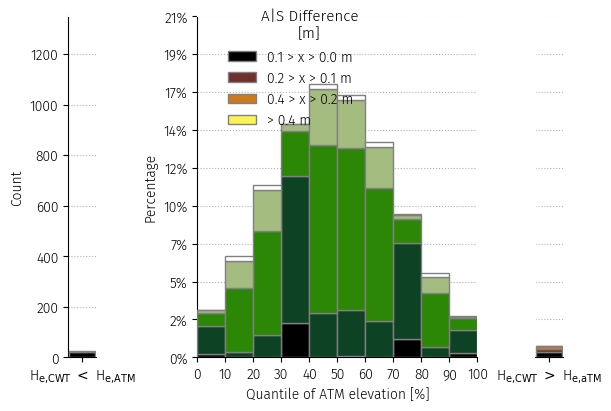

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(6, 4), width_ratios=[.1, 1, .1], constrained_layout=True)

# Extract the keys and values from snow_depths_counted
keys1 = list(a_s_elevations_counted.keys())
values1 = [list(a_s_elevations_counted[key].values()) for key in keys1]
labels1 = [list(a_s_elevations_counted[key].keys()) for key in keys1]
keys1 = np.array(keys1) + .5
colors1 = cmr.jungle(np.linspace(0, 1, len(labels1[8])))

# Create a stacked bar chart for the main plot
bottom = np.zeros(len(keys1))

for i in range(len(labels1[8])):
    heights = [values1[j][i] if i < len(values1[j]) else 0 for j in range(len(values1))]
    ax[1].bar(keys1, heights, width=1, bottom=bottom, 
            # label=f'{labels1[8][i+1]:.1f} > x > {labels1[8][i]:.1f} m' if labels1[8][i] != labels1[8][-1] else f'> {labels1[8][i]:.1f} m',

              color=colors1[i], edgecolor='grey', zorder=100)
    bottom += heights

# Plot for under_snow_depths as a stacked bar chart
under_keys = [0]  # Single x value
under_values = list(under_a_s_elevations_counted.values())
under_labels = list(under_a_s_elevations_counted.keys())
over_keys = [0]  # Single x value
over_values = list(over_a_s_elevations_counted.values())
over_labels = list(over_a_s_elevations_counted.keys())
colors2 = cmr.amber(np.linspace(0, 1, len(over_labels)))

bottom = 0
for i in range(len(under_labels)):
    ax[0].bar(under_keys, under_values[i], width=0.1, bottom=bottom, color=colors2[i], edgecolor='grey', zorder=100)
    bottom += under_values[i]
    
# ax[0].set_title('Under Snow Depths')
ax[0].set_xticks([0])
ax[0].set_xticklabels([r'H$_\text{e,CWT}$ $<$ H$_\text{e,ATM}$'])
# Plot for over_snow_depths as a stacked bar chart

bottom = 0
for i in range(len(over_labels)):
    ax[2].bar(over_keys, over_values[i], width=0.1,
              bottom=bottom,
              label=f'{over_labels[i+1]:.1f} > x > {over_labels[i]:.1f} m' if over_labels[i] != over_labels[-1] else f'> {over_labels[i]:.1f} m',
              color=colors2[i], edgecolor='grey', zorder=100)
    
    bottom += over_values[i]
# ax[2].set_title('Over Snow Depths')
ax[2].set_xticks([0])
ax[2].set_xticklabels([r'H$_\text{e,CWT}$ $>$ H$_\text{e,aTM}$'])
# Set labels and titles

ax[1].set_xlabel('Quantile of ATM elevation [%]')
ax[1].set_xticks(np.arange(0, 11, 1))
ax[1].set_xticklabels([f'{(key) * 10:.0f}' for key in np.arange(0, 11, 1)])
ax[0].set_ylabel('Count')
fig.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.35, .92), ncols=1)

# Set x-axis limits
ax[1].set_xlim(0, 10)

# Set grid and spine colors
# for a in ax:
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].grid(ls=':', axis='y')

ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')
# ax[1].spines['left'].set_color('white')
# ax[1].tick_params(axis='y', colors='white')
ax[1].grid(ls=':', axis='y')

ax[2].spines['top'].set_color('white')
ax[2].spines['left'].set_color('white')
ax[2].grid(ls=':', axis='y')

ax[2].yaxis.tick_right()

ax[2].spines['right'].set_color('white')
# ax[2].spines['left'].set_color('white')
ax[2].tick_params(axis='y', colors='white')
# ax[1].text(0.40, 1.02, 'A|S elevation\n[m]', transform=ax[1].transAxes, ha='center', va='top',fontsize=11)
ax[1].text(0.4, 1.02, 'A|S Difference\n[m]', transform=ax[1].transAxes, ha='center', va='top', fontsize=11)


ys = np.arange(0, 1500, 150)

ax[1].set_yticks(ys)
ax[2].set_yticks(ys)
ax[1].set_ylabel('Count', )

# ax[0].set_yticklabels([f'{i}' for i in ys])
ax[1].set_yticklabels([f'{i / len(df_supermaster_subset)*100:.0f}%' for i in ys])
ax[1].set_ylabel('Percentage', )
# ax[2].yaxis.set_label_position("right")

ax[0].set_ylim(min(ys), max(ys))
ax[1].set_ylim(min(ys), max(ys))
ax[2].set_ylim(min(ys), max(ys))


plt.show()

### Same for snow--ice interface

Text(0.5, 0, '$\\overline{\\text{H}_{\\text{e, ATM}}}$ - $\\overline{\\text{h}_{\\text{s,MP}}}$ [m]')

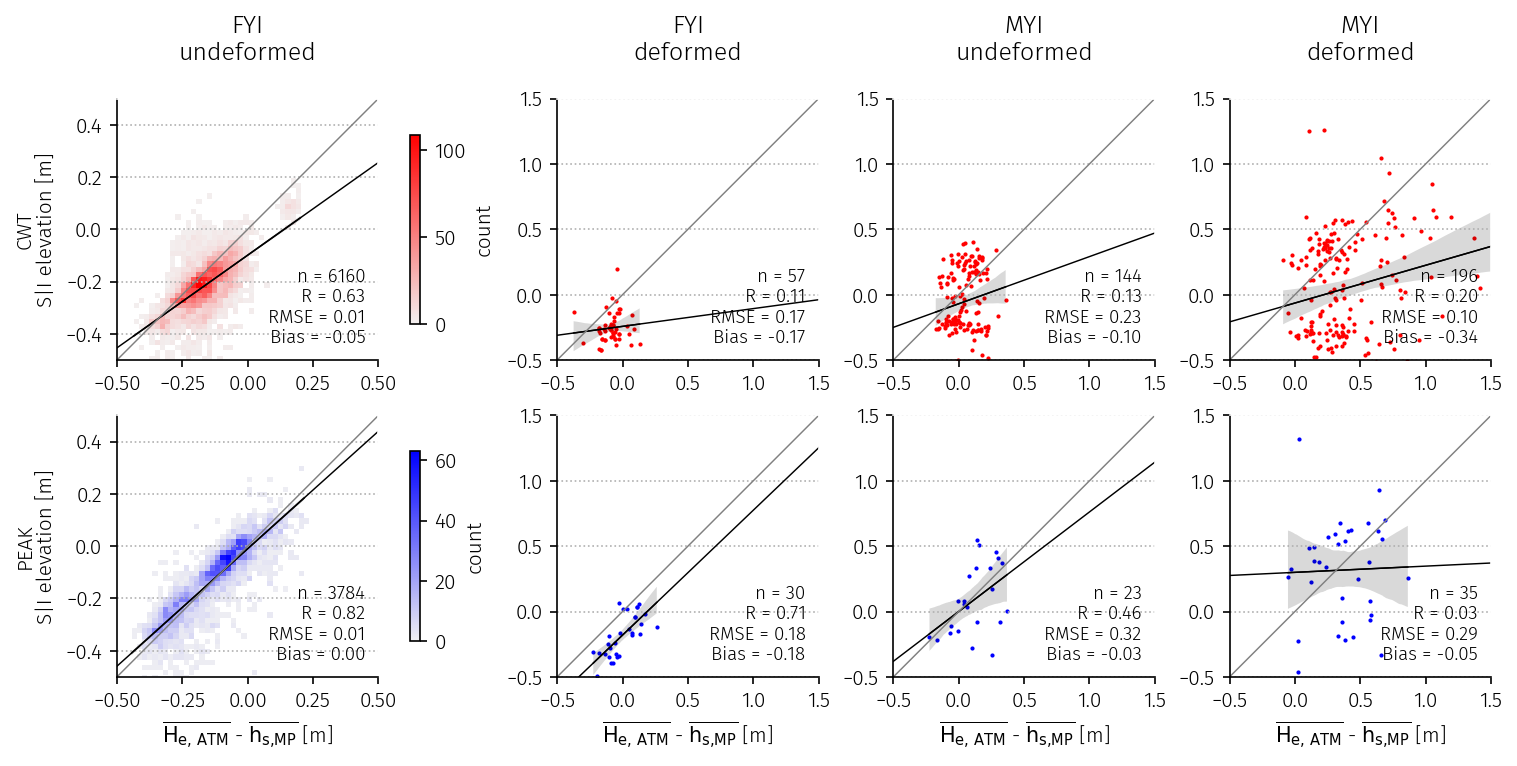

In [9]:
fig, ax = plt.subplots(2,4, constrained_layout=True, figsize=(10,5), dpi=150)
xs = np.linspace(-.5,2.5,100)
colors = ['red', 'blue', 'saddlebrown']
cmaps = [sns.color_palette("light:red", as_cmap=True), sns.color_palette("light:blue", as_cmap=True), sns.color_palette("light:saddlebrown", as_cmap=True)]

ax = ax.ravel()
ax[0].set_title('FYI\nundeformed', y=1.1)
ax[1].set_title('FYI\ndeformed', y=1.1)
ax[2].set_title('MYI\nundeformed', y=1.1)
ax[3].set_title('MYI\ndeformed', y=1.1)

k = 0
color_k = 0

for var, ATM_var in zip(['snow_ice_elevation', 'snow_ice_elevation_peakiness'], ['ATM_elev_wavelet', 'ATM_elev_peakiness']):
  
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)
    if var == 'max_elevation':
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]- df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
        
    else:
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask] - df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    hist = sns.histplot(x=x,y=y,ax=ax[k],
                cmap=cmaps[color_k],
                bins=30,
                binwidth=.02,
                cbar=True,
                cbar_kws={'shrink': .7, 'label': 'count'},
                stat='count'
                )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    
    #########
    
    mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 1)
    if var == 'max_elevation':
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]- df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
        
    else:
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask] - df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    #########

    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 0)
    if var == 'max_elevation':
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]- df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
        
    else:
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask] - df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1

    #########
    
    mask = (df_supermaster['ice_age'] == 'myi') & (df_supermaster['deformation_flag'] == 1)
    if var == 'max_elevation':
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask]- df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
        
    else:
        x = df_supermaster[ATM_var].apply(lambda x: np.nanmean(x))[mask] - df_supermaster['MP_snow_depth'].apply(lambda x: np.nanmean(x))[mask]    
        y = df_supermaster[var][mask]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    ax[k].scatter(x, y,
                  color=colors[color_k],
                  s=1
                  )
    linr = linregress(x,y)
    ax[k].plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
    sns.regplot(x=x, y=y, ax=ax[k], scatter=False, color='black', line_kws={'lw':.7})
    
    n= len(x)
    bias = np.nanmean(y-x)
    ax[k].text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax[k].transAxes, ha='right', va='bottom', size=9)
    k+=1
    color_k+=1


  
 
for i in range(len(ax)):
    ax[i].spines['top'].set_color('white')
    ax[i].spines['right'].set_color('white')
    ax[i].grid(ls=':',axis='y')
    ax[i].set_aspect('equal')
    # ax[i].set_ylabel('SR snow depth [m]')
    ax[i].set_xlim([-0.5, 1.5])
    ax[i].set_ylim([-0.5, 1.5])
    ax[i].plot([-.5, 1.5], [-.5, 1.5], color='grey',lw=.7)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')


ax[0].set_xlim([-.5, .5])
ax[0].set_ylim([-.5, .5])
ax[0].set_ylabel('CWT\nS|I elevation [m]')

ax[4].set_xlim([-.5, .5])
ax[4].set_ylim([-.5, .5])
ax[4].set_ylabel('PEAK\nS|I elevation [m]')

# ax[8].set_xlim([-.5, .5])
# ax[8].set_ylim([-.5, .5])
# ax[8].set_ylabel('MAX\nS|I elevation [m]')


# ax[0].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[1].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[2].set_xlabel('ATM elevation [m]\n(90% quantile)')
# ax[3].set_xlabel('ATM elevation [m]\n(90% quantile)')

ax[4].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]')
ax[5].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]')
ax[6].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]')
ax[7].set_xlabel(r'$\overline{\text{H}_{\text{e, ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]')



(-0.5, 1.5)

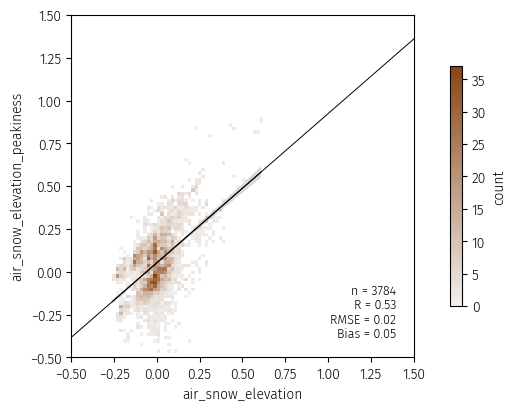

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.set_aspect('equal')
mask = (df_supermaster['ice_age'] == 'fyi') & (df_supermaster['deformation_flag'] == 0)

x = df_supermaster['air_snow_elevation'][mask]  
y = df_supermaster['air_snow_elevation_peakiness'][mask]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

hist = sns.histplot(x=x,y=y,ax=ax,
            cmap=cmaps[color_k],
            bins=30,
            binwidth=.02,
            cbar=True,
            cbar_kws={'shrink': .7, 'label': 'count'},
            stat='count'
            )
linr = linregress(x,y)
ax.plot(xs, xs*linr.slope + linr.intercept, color='black', lw=.7)
sns.regplot(x=x, y=y, ax=ax, scatter=False, color='black', line_kws={'lw':.7})
n= len(x)
bias = np.nanmean(y-x)
ax.text(0.95, 0.05, f'n = {n}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}\nBias = {bias:.2f}', transform=ax.transAxes, ha='right', va='bottom', size=9)

ax.set_xlim([-.5, 1.5])
ax.set_ylim([-.5, 1.5])
